# Ligand-based Screening - Solution

Your task here is to implement a virtual screening pipeline for unknown compounds using a machine learning approach. 

In [327]:
# Do not forget to import the needed libraries
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Draw, DataStructs
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.ML.Cluster import Butina

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import recall_score

import matplotlib.pyplot as plt


### Task 1: Data Preparation
To make the ML part easier for you, we have prepared an EGFR dataset for training (`./data/ChEMBL25_activities_EGFR.csv`). Your task is to predict whether a compound is active or not. For the model, you will encode your compounds using fingerprints. Like before, first read in the data into a data frame, then calculate the Morgan fingerprints for all given compounds. 

In [328]:
# read in file 
df=pd.read_csv('./data/ChEMBL25_activities_EGFR.csv')
df.head()

,Unnamed: 0,chembl_id,IC50,units,canonical_smiles,pIC50
0,1777,CHEMBL207869,77.0,nM,Fc1cccc(COc2ccc(Nc3ncncc3C#Cc4ncccn4)cc2Cl)c1,7.113509
1,5785,CHEMBL3940060,330.0,nM,Fc1ccc(Nc2ncnc3cc4OC(=O)N(CCOC(=O)CCl)c4cc23)c...,6.481486
2,6373,CHEMBL3678951,1.0,nM,CC(C)n1c(Nc2cccc(c2)C(F)(F)F)nc3cnc(Nc4ccc(cc4...,9.000000
3,2442,CHEMBL504034,40.0,nM,CS(=O)(=O)CCNC(=O)O[C@H]1CN[C@@H](C1)C#Cc2cc3n...,7.397940
4,1084,CHEMBL158797,43000.0,nM,Cn1c(SSc2c(C(=O)NCC(O)CO)c3ccccc3n2C)c(C(=O)NC...,4.366532


In [329]:
# morgan fingerprint 
mols = []
for entry in df['canonical_smiles']:
    mols.append(Chem.MolFromSmiles(entry))

fps = []
for mol in mols:
    fps.append(GetMorganFingerprintAsBitVect(mol,2))

df['molecule'] = mols
df['morgan'] = fps




Now, add a column in your data frame indicating whether a compound is active or not. Set the values 1, 0 for active, inactive compounds respectively using activity cutoff to pIC50 = 6.3.

In [330]:
# compound activity
df['active'] = df['pIC50'].map(lambda x:x>6.3).astype(int)

# remove unnecessary columns from dataframe 
df.drop(['IC50','units','Unnamed: 0'], axis=1, inplace=True)
df.head()

,chembl_id,canonical_smiles,pIC50,molecule,morgan,active
0,CHEMBL207869,Fc1cccc(COc2ccc(Nc3ncncc3C#Cc4ncccn4)cc2Cl)c1,7.113509,<rdkit.Chem.rdchem.Mol object at 0x18e072b00>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
1,CHEMBL3940060,Fc1ccc(Nc2ncnc3cc4OC(=O)N(CCOC(=O)CCl)c4cc23)c...,6.481486,<rdkit.Chem.rdchem.Mol object at 0x18db68e20>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",1
2,CHEMBL3678951,CC(C)n1c(Nc2cccc(c2)C(F)(F)F)nc3cnc(Nc4ccc(cc4...,9.000000,<rdkit.Chem.rdchem.Mol object at 0x18db692a0>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",1
3,CHEMBL504034,CS(=O)(=O)CCNC(=O)O[C@H]1CN[C@@H](C1)C#Cc2cc3n...,7.397940,<rdkit.Chem.rdchem.Mol object at 0x18db6b9a0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
4,CHEMBL158797,Cn1c(SSc2c(C(=O)NCC(O)CO)c3ccccc3n2C)c(C(=O)NC...,4.366532,<rdkit.Chem.rdchem.Mol object at 0x18d1694e0>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0


### Task 2: Machine Learning 

Train a Random Forest model using the data prepared above. Set the random state to 0 for reproducible results. Split your data into 80% training and 20% test data and set the seed to 1234 for reproducible results. 

In [331]:
# random forest model 

def build_random_forest_model(X_train, X_test, y_train, y_test, nb_tree=100, nb_dec=3):
    """
    Trains a Random Forest model with ``nb_tree`` trees using X_train and y_train and predict using X_test. 
    
    Parameters
    ----------
    X_train: array_like
        Input data to train the model
    X_test: array_like
        Input data to test the model  
    y_train: array
        Output value in the train set
    y_test: array
        Output value in the test set
    nb_tree: int
        number of trees to build for the forest
    nb_dec: int
        number of decimals to considers for the metrics
    
    Returns
    -------
    dict:
        ``"Probability"``
            probability of belonging to class 1 and class 0 in (`array`) type.
        ``'Accuracy'``
            accuracy of the model (`float`).
        ``'AUC'`` AUC of the model (`float`).
        ``'Sensitivity'`` Sensitivity of the model (`float`).
        ``'Specificity'`` Specificity of the model (`float`).
    """
    
    # Initialize Random Forest with nb_tree of trees
    forest = RandomForestClassifier(n_estimators=nb_tree)
    
    # Train the model
    forest.fit(X_train, y_train)
    
    # Obtain probability of belonging to class 0 and 1
    y_prob = forest.predict_proba(X_test)
    
    # Predict the output class of the test set
    y_pred = forest.predict(X_test)
    
    # Compute metrics
    accuracy = metrics.accuracy_score(y_test, y_pred).round(nb_dec)
    auc = metrics.roc_auc_score(y_test, y_prob[:,1]).round(nb_dec)
    sensitivity = metrics.recall_score(y_test, y_pred, pos_label=1).round(nb_dec)
    specificity = metrics.recall_score(y_test, y_pred, pos_label=0).round(nb_dec)
    
    return {'Probability': y_prob,
           'Accuracy': accuracy,
           'AUC': auc,
           'Sensitivity': sensitivity,
           'Specificity': specificity, 
           'forest': forest}

In [332]:
# Split data into training set (80%) and test set (20%), shuffling the data and setting the seed
output = df['active'].tolist()
x_morgan_train, x_morgan_test, y_morgan_train, y_morgan_test = train_test_split(fps, output,
                                                                                test_size=0.2,
                                                                                shuffle=True,
                                                                                random_state=42)

To evaluate your model, calculate the accuracy, AUC, sensitivity, and specificity values (for sensitivity and specificity search for the sklearn function recall_score).

In [333]:
# model evaluation
result_morgan = build_random_forest_model(x_morgan_train, x_morgan_test, y_morgan_train, y_morgan_test)
forest = result_morgan['forest']
result_morgan

{'Probability': array([[0.95, 0.05],
        [0.88, 0.12],
        [0.14, 0.86],
        ...,
        [1.  , 0.  ],
        [0.96, 0.04],
        [0.07, 0.93]]),
 'Accuracy': 0.84,
 'AUC': 0.911,
 'Sensitivity': 0.903,
 'Specificity': 0.75,
 'forest': RandomForestClassifier()}

### Task 3: Compound Filtering 

Filter the compounds in "data/test_compounds_EGFR.csv" down to 20 compounds. For this, you can combine I) classical similarity searches/substructure searches II) predictions via a machine learning approach, III) filtering criteria based on molecular properties (Lipinski's rule of five) IV) and/or clustering. Note that you will predict the binding affinity and binding mode of your selected subset via docking for further filtering. It might be wise to have a selected set of diverse compounds, e.g. obtained using different selection criteria.


* Read in the data containing the unknown compounds. Start your filtering with an activity prediction using the trained random forest model. If you have time, feel free to try out different models (e.g. what you have seen in previous sessions) and choose your favorite one for the filtering. 


In [334]:
# read in unknown compounds 
data_test = pd.read_csv("./data/test_compounds_EGFR.csv")
data_test.head()

,Unnamed: 0,chembl_id,canonical_smiles
0,1927,CHEMBL101253,Clc1ccc(Nc2nnc(Cc3ccncc3)c4ccccc24)cc1
1,212,CHEMBL107472,CNc1ncc2C=C(C(=O)N(C)c2n1)c3c(Cl)cccc3Cl
2,3089,CHEMBL1077068,CC1=C(C(NC(=N1)Nc2ccc(cc2)S(=O)(=O)Nc3ncccn3)c...
3,3126,CHEMBL1088240,COc1cc(Nc2c(cnc3cc(\C=C\CCN4CCN(C)CC4)c(OC)cc2...
4,3125,CHEMBL1092382,CCC(=O)Nc1ccc2nccc(Nc3cccc(Br)c3)c2c1


In [335]:
# Convert smiles in data_test to morgan fingerprints
smiles_test = data_test["canonical_smiles"].tolist()
morgan_fp_test = []
test_mols = []

for smiles in smiles_test:
    mol = Chem.MolFromSmiles(smiles)
    test_mols.append(mol)
    morgan_fp_test.append(GetMorganFingerprintAsBitVect(mol,2))

data_test["morgan"] = morgan_fp_test
data_test["molecule"] = test_mols
data_test.drop(['Unnamed: 0'], axis=1, inplace=True)


In [336]:
data_test.head()

,chembl_id,canonical_smiles,morgan,molecule
0,CHEMBL101253,Clc1ccc(Nc2nnc(Cc3ccncc3)c4ccccc24)cc1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x18e0222c0>
1,CHEMBL107472,CNc1ncc2C=C(C(=O)N(C)c2n1)c3c(Cl)cccc3Cl,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x18da63580>
2,CHEMBL1077068,CC1=C(C(NC(=N1)Nc2ccc(cc2)S(=O)(=O)Nc3ncccn3)c...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x18da63ee0>
3,CHEMBL1088240,COc1cc(Nc2c(cnc3cc(\C=C\CCN4CCN(C)CC4)c(OC)cc2...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",<rdkit.Chem.rdchem.Mol object at 0x18d752020>
4,CHEMBL1092382,CCC(=O)Nc1ccc2nccc(Nc3cccc(Br)c3)c2c1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x18d752260>


In [338]:
# Predict the output class of the test set: active/inactive and add to dataframe 
y_pred = forest.predict(morgan_fp_test)
data_test['active/inactive'] = y_pred

# Obtain probability of belonging to a class active/inactive for the test set and add to dataframe
y_prob = forest.predict_proba(morgan_fp_test)
data_test['0 prob'] = y_prob[:,0]
data_test['1 prob'] = y_prob[:,1]

In [339]:
nb_active = (data_test['active/inactive'] == 1).sum()
print(f'Number of compounds predicted active: {nb_active}.')


Number of compounds predicted active: 659.


In [340]:
# create new dataframe containing only compounds predicted to be active 
active_df = data_test[data_test['active/inactive'] == 1]
active_df.head()

,chembl_id,canonical_smiles,morgan,molecule,active/inactive,0 prob,1 prob
3,CHEMBL1088240,COc1cc(Nc2c(cnc3cc(\C=C\CCN4CCN(C)CC4)c(OC)cc2...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",<rdkit.Chem.rdchem.Mol object at 0x18d752020>,1,0.290,0.710
4,CHEMBL1092382,CCC(=O)Nc1ccc2nccc(Nc3cccc(Br)c3)c2c1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x18d752260>,1,0.285,0.715
12,CHEMBL1097368,C(Cc1cc2c(Nc3ccc4[nH]ccc4c3)ncnc2[nH]1)c5ccccc5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x18d7529e0>,1,0.320,0.680
14,CHEMBL113023,COc1ccc(Nc2ncc3C=C(C(=O)N(C)c3n2)c4c(Cl)cccc4C...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x18d752b60>,1,0.330,0.670
15,CHEMBL113070,CN1C(=O)C(=Cc2cnc(Nc3ccc(CCCC(=O)O)cc3)nc12)c4...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x18d752c20>,1,0.240,0.760


As a first filtering we have chosen to apply Lipinski's rule of five. We filter out all compounds violating more than one of the Lipinski rules. 

In [341]:

def test_rule_of_five(smi):
    """
    Checks if molecule fulfills the Lipinski's rule of five. Calculates the molecular descriptors and checks for all rules. 
    We allow one mismatch in the rules. 
    
    Parameters
    ----------
    smi: string
        smiles string of compound 
    
    Returns
    -------
    bool: indicating True if Lipinski's rule of five holds. 
    """

    m = Chem.MolFromSmiles(smi)
    
    # Calculate rule of five chemical properties
    MW = Descriptors.ExactMolWt(m)
    HBA = Descriptors.NumHAcceptors(m)
    HBD = Descriptors.NumHDonors(m)
    LogP = Descriptors.MolLogP(m)
    
    # Rule of five conditions
    conditions = [MW <= 500, HBA <= 10, HBD <= 5, LogP <= 5]
    # Return True if no more than one out of four conditions is violated
    return conditions.count(True) >= 3


In [342]:
# filter lipinski, save filtered compounds to dataframe 
filtered_df = active_df.copy(deep=True)
filtered_df['lipinski'] = active_df['canonical_smiles'].apply(test_rule_of_five).copy(deep=True)
filtered_df = filtered_df[filtered_df['lipinski']]
filtered_df.shape

(530, 8)

As a next filtering step we apply Butina clustering. First we calculate the pairwise distances, then we run the clustering algorithm. Afterwards we select a compound from each cluster. This reduces the number of compounds and makes the filtered set more diverse. 

In [343]:
def tanimoto_distance_matrix(fp_list):
    """Calculate distance matrix for fingerprint list"""
    dissimilarity_matrix = []
    # Notice how we are deliberately skipping the first and last items in the list
    # because we don't need to compare them against themselves
    for i in range(1, len(fp_list)):
        # Compare the current fingerprint against all the previous ones in the list
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i], fp_list[:i])
        # Since we need a distance matrix, calculate 1-x for every element in similarity matrix
        dissimilarity_matrix.extend([1 - x for x in similarities])
    return dissimilarity_matrix

In [344]:
# Fingerprints as lists
fingerprints=filtered_df["morgan"].to_list()
# Calculate distance matrix
dist_matrix = tanimoto_distance_matrix(fingerprints)
# Define distance cut-off
cutoff=0.7

In [345]:
# clustering 
clusters = Butina.ClusterData(dist_matrix, len(fingerprints), cutoff, isDistData=True)
clusters = sorted(clusters, key=len, reverse=True)

In [346]:
# get indexes of compounds we want to keep (one index for each cluster)
cluster_indexes = []
for cluster in clusters: 
    cluster_indexes.append(cluster[0])

In [347]:
# create dataframe with remaining compounds 
cluster_df = filtered_df.iloc[cluster_indexes]
cluster_df.shape

(40, 8)

In [348]:
cluster_df.head()

,chembl_id,canonical_smiles,morgan,molecule,active/inactive,0 prob,1 prob,lipinski
347,CHEMBL2447950,Cl.CCOc1cc2ncnc(Nc3cccc(Cl)c3)c2cc1OCC,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x18d7622c0>,1,0.04,0.96,True
615,CHEMBL3671504,Fc1cc(Br)ccc1Nc2ncnc3cc(OCCC=C)c(NC(=O)C=C)cc23,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x18d76ec80>,1,0.00,1.00,True
106,CHEMBL138940,Fc1ccc(Nc2ncnc3cnc(NC(=O)\C=C\C(=O)NCCCN4CCOCC...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x18d756f20>,1,0.01,0.99,True
757,CHEMBL394056,COCc1ccn2ncnc(Nc3ccc4c(cnn4Cc5cccc(F)c5)c3)c12,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x18d775780>,1,0.09,0.91,True
509,CHEMBL3301625,COCCOc1ccc(Nc2ncc(F)c(Nc3cccc(NC(=O)C=C)c3)n2)cc1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x18d769cc0>,1,0.30,0.70,True


As a last filtering step, we look at the results from the random forest again. In addition to a classification results, we can also look at the classification probability. We want to only keep compounds with a high probability of being classified as active (1). 


In [349]:
# filter with RF probability
cluster_df = cluster_df[cluster_df["1 prob"] > 0.95]
cluster_df.shape

(11, 8)

Finally, we can display our chosen compounds. 

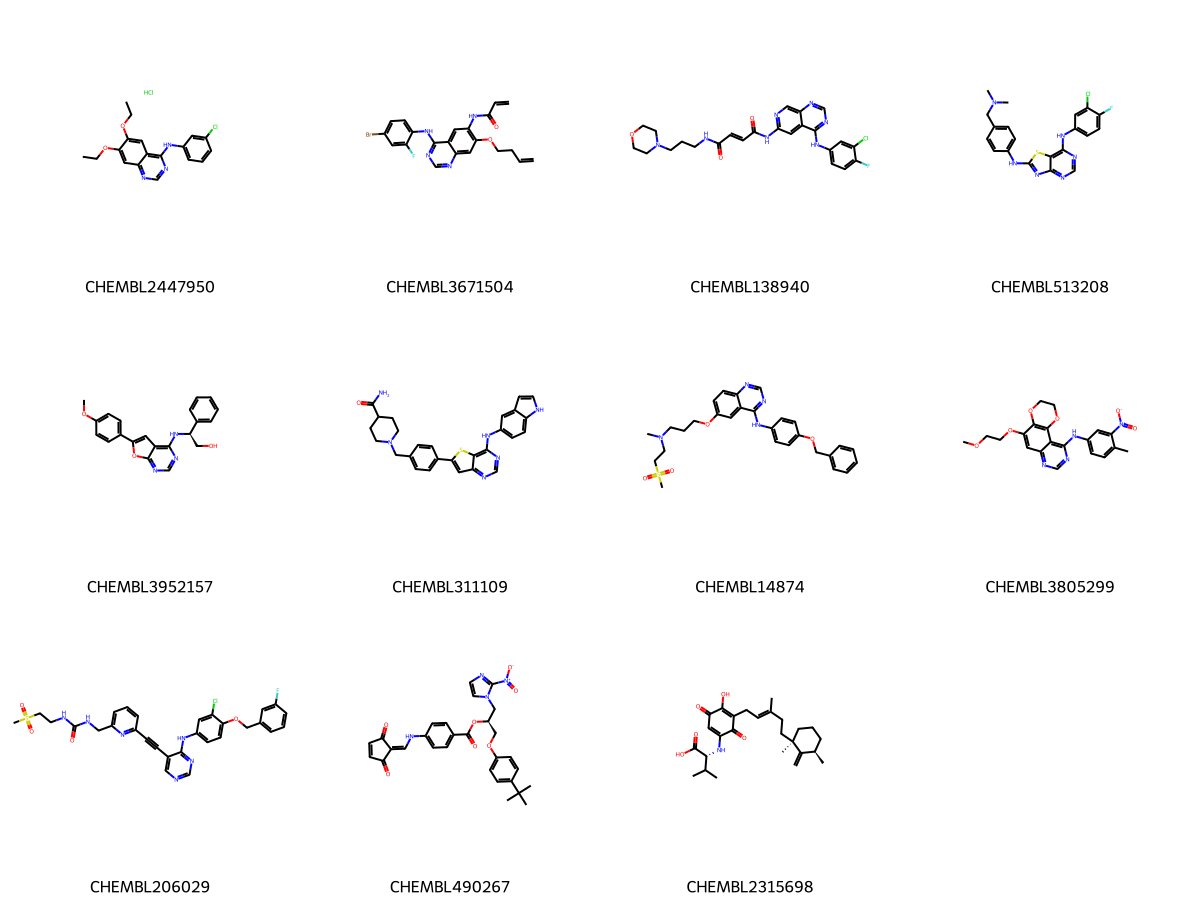

In [350]:

list_compounds = [Chem.MolFromSmiles(smiles) for smiles in cluster_df['canonical_smiles']]

Draw.MolsToGridImage(list_compounds, molsPerRow=4,subImgSize=(300,300), legends=cluster_df['chembl_id'].tolist())

In [351]:
cluster_df.head()

,chembl_id,canonical_smiles,morgan,molecule,active/inactive,0 prob,1 prob,lipinski
347,CHEMBL2447950,Cl.CCOc1cc2ncnc(Nc3cccc(Cl)c3)c2cc1OCC,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x18d7622c0>,1,0.0400,0.9600,True
615,CHEMBL3671504,Fc1cc(Br)ccc1Nc2ncnc3cc(OCCC=C)c(NC(=O)C=C)cc23,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x18d76ec80>,1,0.0000,1.0000,True
106,CHEMBL138940,Fc1ccc(Nc2ncnc3cnc(NC(=O)\C=C\C(=O)NCCCN4CCOCC...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x18d756f20>,1,0.0100,0.9900,True
919,CHEMBL513208,CN(C)Cc1ccc(Nc2nc3ncnc(Nc4ccc(F)c(Cl)c4)c3s2)cc1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x18d77d180>,1,0.0200,0.9800,True
765,CHEMBL3952157,COc1ccc(cc1)c2oc3ncnc(N[C@H](CO)c4ccccc4)c3c2,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x18d775d80>,1,0.0175,0.9825,True


To continue with the structure-based pipeline, we need to write the molecules to a file, so we have our final compounds. 

In [352]:
# write to file, we only need the chembl id and the smiles string 
cluster_df.to_csv('data/filtered_compounds.csv', columns=['chembl_id', 'canonical_smiles'], index=False)